In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
! pip install pydlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
# 2. Đọc file dữ liệu chứng khoán VNDIRECT
df = pd.read_csv('/content/drive/MyDrive/1.PTDLKD/Dataset/VNDIRECT_STOCK.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/12/2017,16511.9,16477.2,16615.9,16338.4,1.06M,1.28%
1,4/12/2017,16997.5,16720.0,17309.7,16615.9,1.60M,2.94%
2,5/12/2017,16303.7,16997.5,16997.5,16303.7,2.36M,-4.08%
3,6/12/2017,16234.4,16234.4,16373.1,15748.7,2.62M,-0.43%
4,7/12/2017,15818.1,16303.7,16338.4,15679.3,1.07M,-2.56%
...,...,...,...,...,...,...,...
1368,8/6/2023,18100.0,19200.0,19500.0,18100.0,66.28M,-5.97%
1369,9/6/2023,18950.0,18300.0,19000.0,18100.0,43.03M,4.70%
1370,12/6/2023,18850.0,19000.0,19050.0,18350.0,24.09M,-0.53%
1371,13/06/2023,18650.0,18950.0,19050.0,18600.0,25.97M,-1.06%


In [32]:
df = df[['Price','Date','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,1373.0,14755.429133,8039.411686,2578.0,8313.4,15288.0,19902.3,34784.3
High,1373.0,15056.402039,8248.531148,2602.1,8372.8,15660.8,20275.3,36254.0


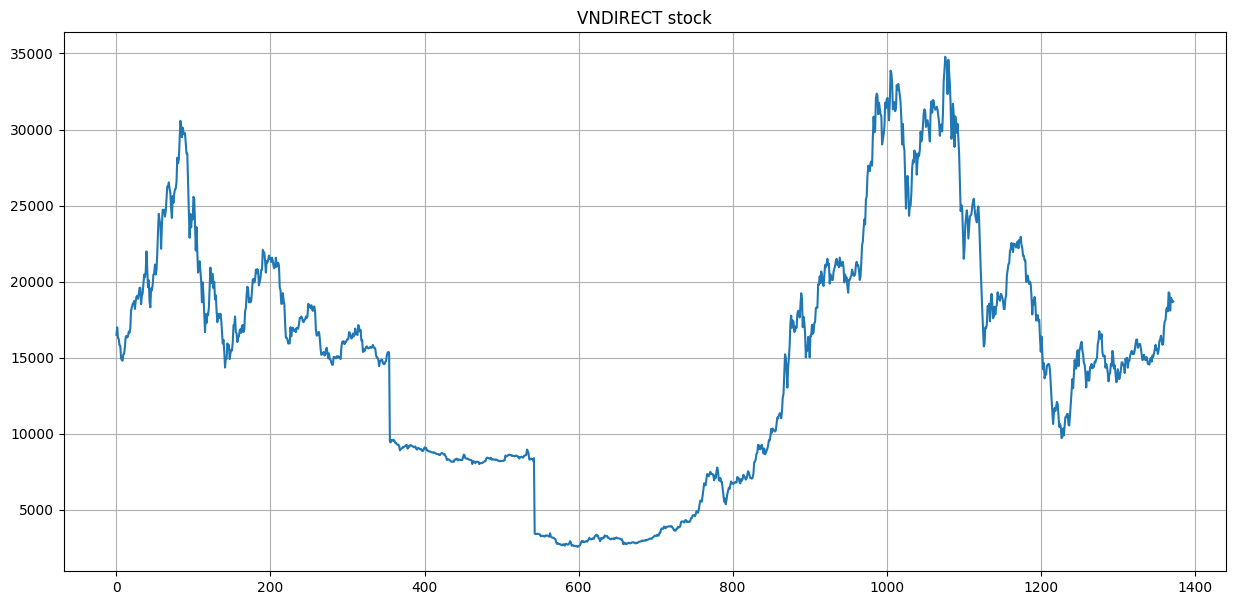

In [34]:
plt.figure(figsize=(15, 7))
plt.plot(df['Price'])
plt.title('VNDIRECT stock')
plt.grid(True)
plt.show()

In [35]:
#chia train test validate theo tỉ lệ 7:1:2
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

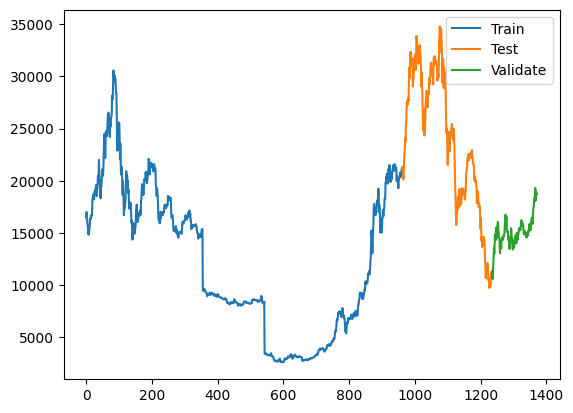

In [36]:
#Vẽ biểu đồ chia tập train, test, validate
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index,val_data['Price'])
plt.legend(['Train', 'Test','Validate',])
plt.show()

In [37]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

In [44]:
#Train model dlm
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
high_feature = []
for price in train_data['High']:
  high_feature.append([price])
print(high_feature)
# Define the DLM model
model = dlm(y_train)
# Add a linear trend component and add a first-order trend (linear trending) with prior covariance 1.0
model = model + trend(1, name='lineTrend', w=1.0)
model = model + autoReg(degree=1, data=y_train, name='ar1', w=1e7) + dynamic(features=high_feature, discount=1, name='High')
model.fit()

[[16615.9], [17309.7], [16997.5], [16373.1], [16338.4], [16026.2], [15610.0], [15193.7], [15124.3], [15228.4], [15332.5], [15887.5], [16442.5], [16720.0], [16546.6], [16477.2], [16858.8], [16858.8], [17205.7], [18107.6], [18662.6], [18593.2], [18905.4], [18801.3], [18801.3], [18801.3], [19356.4], [19252.3], [19078.9], [19564.5], [19703.3], [19703.3], [19703.3], [19078.9], [19425.7], [20223.6], [20813.3], [20813.3], [21160.2], [21992.7], [22409.0], [21021.4], [20084.8], [19737.9], [18697.3], [19564.5], [20258.3], [19772.6], [20466.4], [20917.4], [21264.2], [21056.1], [20813.3], [22166.2], [23380.6], [24909.3], [24639.5], [24055.0], [24189.9], [23695.3], [25314.0], [25089.2], [25448.9], [24999.2], [24684.5], [25718.6], [26258.2], [26528.0], [26887.7], [26707.8], [26438.0], [25898.5], [24459.7], [25628.7], [25673.7], [25763.6], [26078.3], [26528.0], [26797.7], [28371.4], [28776.1], [28056.7], [29450.5], [30574.6], [30934.3], [30664.5], [30125.0], [30754.5], [30125.0], [30125.0], [30259.9]

In [45]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Price'])
y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'High': x_test})
y_pred = y_pred[0]

(274, 1)


In [46]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = model.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[11322.717190190353, 12234.557518748752, 11424.28362435137, 12022.208112705259, 12720.245385390617, 13455.318241479, 14184.791159653238, 14706.418561522907, 14320.35796206636, 15375.87022076176, 15848.199086015456, 15104.381196381903, 15744.430316525553, 16175.23285205738, 16168.116797972969, 15757.658335152017, 16764.686591987578, 16200.885190962126, 16709.368926107072, 17212.237770768425, 15889.898416606906, 15939.17263064822, 15363.668531095638, 14934.80663565801, 14483.77181453156, 14505.64719840117, 14925.57410976183, 14659.237182908993, 14392.3201452371, 15012.43288853248, 15498.422951826804, 15222.09699509382, 15426.247905490678, 15140.364166102636, 15241.614128554233, 15753.885391024594, 15421.412542375867, 15842.745352675734, 15576.19584791674, 16509.29139481464, 16843.61100009064, 17268.468077426394, 17157.904876556648, 17180.4725643499, 16922.04498143078, 17175.662644183423, 15943.18419276972, 15926.697992982385, 15674.175524163325, 15979.073371209752, 15469.2

In [49]:
# 12. Đánh giá độ chính xác thuật toán
#Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

from sklearn.metrics import mean_squared_error, mean_absolute_error
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 664.454485753069
Testing RMSE: 1246.768072300777
Validation MAPE: 4.221892059400875
Testing MAPE: 5.580618233249313
Validation MAE: 644.1452024702436
Testing MAE: 986.9773260080865


In [50]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[522.58072994 509.40508853 496.22944711 483.0538057  469.87816429
 456.70252287 443.52688146 430.35124005 417.17559863 403.99995722
 390.82431581 377.64867439 364.47303298 351.29739157 338.12175015
 324.94610874 311.77046733 298.59482591 285.4191845  272.24354309
 259.06790167 245.89226026 232.71661885 219.54097743 206.36533602
 193.18969461 180.01405319 166.83841178 153.66277037 140.48712895]


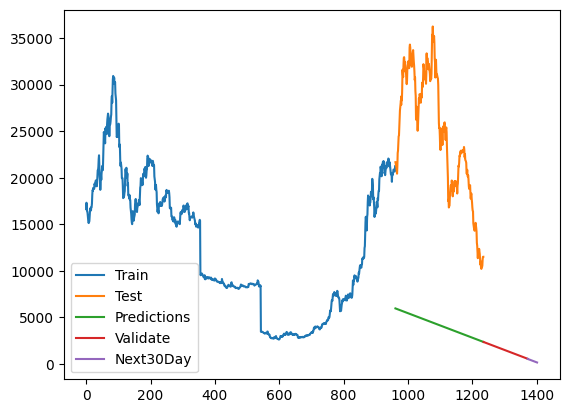

In [51]:
plt.plot(train_data.index, train_data['High'])
plt.plot(test_data.index, test_data['High'])
plt.plot(test_data.index,y_pred_LR)
plt.plot(val_data.index,y_pred_val_LR)
plt.plot(last_data,feature_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()